In [2]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lro
import matplotlib.pyplot as plt
import warnings
import seaborn
import imageio
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive"]

### Example 3: Max of affine uncertainty
We consider a problem with max of affine uncertainty, 

$$g(u,x) = \max_{l=1,\dots,L} (P_lu + a_l)^Tx,$$
where $P_l$ and $a_l$ are constants for all $l = 1, \dots, L$. The robust formulation is 
$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & \max_{l=1,\dots,L} (P_lu + a_l)^Tx  \leq  \tau \quad \forall u \in \mathcal{U}(\theta)\\
& x \geq 0,
\end{array}
$$


where $\theta$ encodes the training parameters $(A,b)$.

In [3]:
# Formulate constants
n = 2
N = 50
# k = npr.uniform(1,4,n)
# p = k + npr.uniform(2,5,n)
k = np.array([2.,3.])
p = np.array([3,4.5])
k_tch = torch.tensor(k, requires_grad = True)
p_tch = torch.tensor(p, requires_grad = True)

# Formulate loss function
def loss(t,x, data,l = 5): 
    return t + l*torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True))), t, torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True)))

def gen_demand(n, N):
    np.random.seed(7)
    F = np.random.normal(size = (n,2))
    sig = 0.1*F@(F.T)
    mu = np.random.uniform(-0.2,3,n)
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train

# Generate data
data = gen_demand(n,N)

### Plot Data

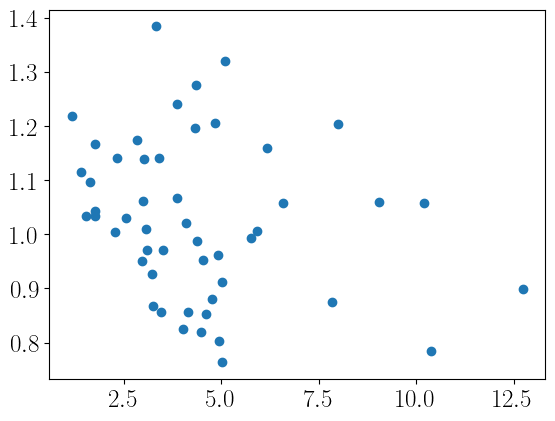

In [4]:
plt.scatter(data[:,0],data[:,1])

### Train relevant sets

In [4]:
n = 2
# Formulate uncertainty set
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()

objective = cp.Minimize(t)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [x_r >= 0]

prob = lro.RobustProblem(objective, constraints)

s = 13
# # Train only epsilon
result = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", initeps = 1, seed = s)
df_eps = result.df
# # Train A and b
init_A = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
init_b = -init_A@np.mean(data, axis=0)
# Train A and b
result1 = prob.train(lr = 0.001, step=250, momentum = 0.8, optimizer = "SGD", seed = s, initA = init_A, initb = init_b, save_iters = True)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

A1_iters, b1_iters = result1.uncset_iters

result2 = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initA = A_fin, initb = b_fin, save_iters = True)
df_r1 = result2.df
A_fin_2 = result2.A
b_fin_2 = result2.b

result3 = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initA = init_A, initb = init_b)
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), initA = init_A, initb = init_b, seed = s)
dfgrid = result4.df

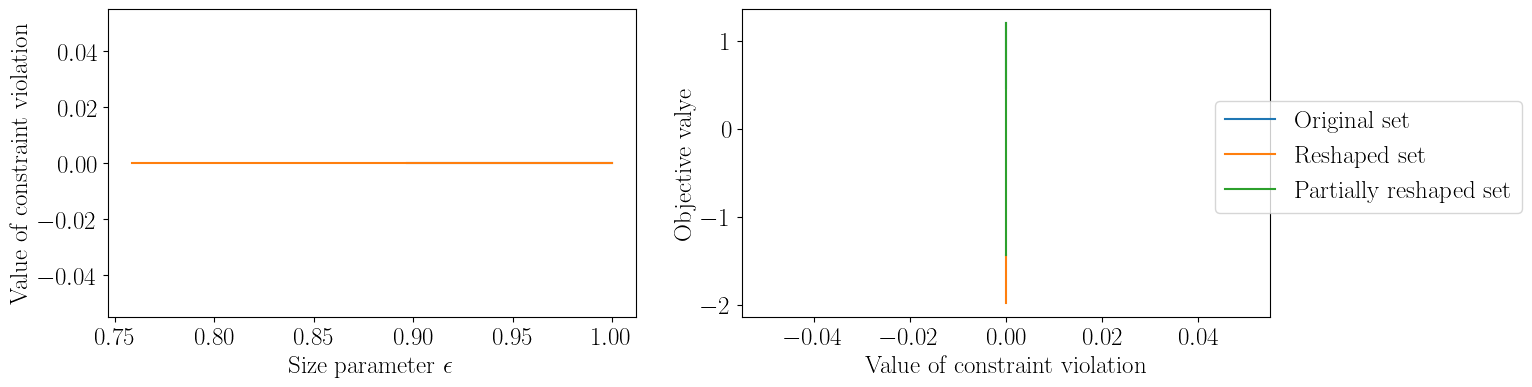

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot((df_r2['A_norm']), df_r2['Violations'], color="tab:blue", label=r"Original set")
ax1.plot((df_r1['A_norm']), df_r1['Violations'], color="tab:orange", label="Reshaped set")
# ax1.set_yscale("log")
ax1.set_xlabel("Size parameter $\epsilon$")
ax1.set_ylabel("Value of constraint violation")

ax2.plot(df_r2['Violations'][:], df_r2['Opt_val'][:], color="tab:blue", label=r"Original set")
ax2.plot(df_r1['Violations'],df_r1['Opt_val'], color="tab:orange", label="Reshaped set")
ax2.plot(df1['Violations'],df1['Opt_val'], color="tab:green", label="Partially reshaped set")
ax2.set_ylabel("Objective valye")
# ax2.set_xlim([-1,20])
ax2.set_xlabel("Value of constraint violation")
lgd = ax2.legend(loc = "lower right", bbox_to_anchor=(1.5, 0.3))
plt.savefig("tradeoff_curves.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

### Solve for final values

In [19]:
def final_solve(A_final, b_final):

    n = 2
    u = lro.UncertainParameter(n,
                            uncertainty_set=lro.Ellipsoidal(p=2,
                                                        A = A_final, b = b_final))
    # Formulate the Robust Problem
    x_r = cp.Variable(n)
    t = cp.Variable()

    objective = cp.Minimize(t)

    constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
    constraints += [x_r >= 0]

    prob = lro.RobustProblem(objective, constraints)
    prob.solve()
    # result3.reform_problem.solve()
    x_final = x_r.value
    t_final = t.value

    return x_final, t_final

x_opt_learned_2, t_opt_learned_2 = final_solve(A_fin_2, b_fin_2)
x_opt_learned, t_opt_learned = final_solve(A_fin, b_fin)
x_opt_base, t_opt_base = final_solve(init_A, init_b)

print("base x,t =", x_opt_base, t_opt_base)
print("optimal x,t =", x_opt_learned, t_opt_learned)
print("after eps train optimal x,t =", x_opt_learned_2, t_opt_learned_2)



ValueError: Incompatible dimensions (2, 8) (2, 1)

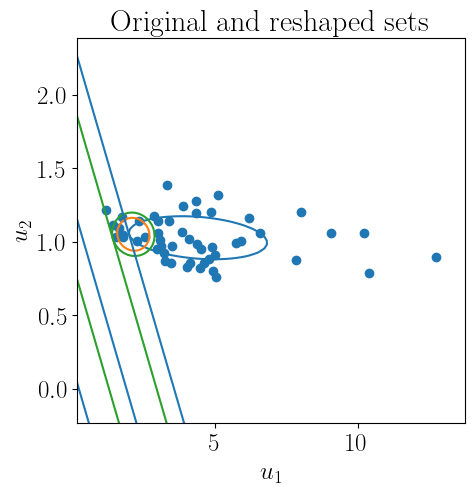

In [14]:
# Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
offset = 1
x_min, x_max = np.min(data[:,0]) - offset, np.max(data[:,0]) + offset
y_min, y_max = np.min(data[:,1]) - offset, np.max(data[:,1]) + offset
n_points = 100
X = np.linspace(x_min,x_max,n_points)
Y = np.linspace(y_min,y_max,n_points)
x_mesh,y_mesh = np.meshgrid(X,Y)

def level_set(A_final, b_final, offset = 2, n = n_points, x_mesh = x_mesh, y_mesh = y_mesh):
    x_opt, t_opt = final_solve(A_final, b_final)
    unc_level_set = np.zeros((n,n))
    g_level_set = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            u_vec = [x_mesh[i,j], y_mesh[i,j]]
            unc_level_set[i,j] = np.linalg.norm(A_final @ u_vec  + b_final)
            g_level_set[i,j] = np.maximum(k @ x_opt - p @ x_opt, k @ x_opt - p @ u_vec) - t_opt

    return unc_level_set, g_level_set


unc_level_learned_2, g_level_learned_2 = level_set(A_fin_2, b_fin_2)
unc_level_learned, g_level_learned = level_set(A_fin, b_fin)
unc_level_base, g_level_base = level_set(init_A, init_b)



plt.figure(figsize=(5, 5))
plt.title("Original and reshaped sets")
# Set axis label for the contour plot
plt.xlabel(r"$u_1$")
plt.ylabel(r"$u_2$")

plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"], label = "initial sets")
plt.contour(x_mesh,y_mesh,unc_level_learned, [1], colors = ["tab:green"], label = "initial train A,b")
plt.contour(x_mesh,y_mesh,unc_level_learned_2, [1], colors = ["tab:orange"], label = "final train")

# plt.pcolormesh(x_mesh, y_mesh,g_level_learned)
plt.contour(x_mesh,y_mesh,g_level_learned, [0, 5, 10], colors = ["tab:green"])
plt.contour(x_mesh,y_mesh,g_level_base, [0, 5, 10], colors = ["tab:blue"])
plt.scatter(data[:,0],data[:,1])
# plt.savefig("Reshaped_ctrs.pdf", bbox_inches='tight')
# plt.legend(loc = "upper center")
plt.show()



KeyboardInterrupt: 

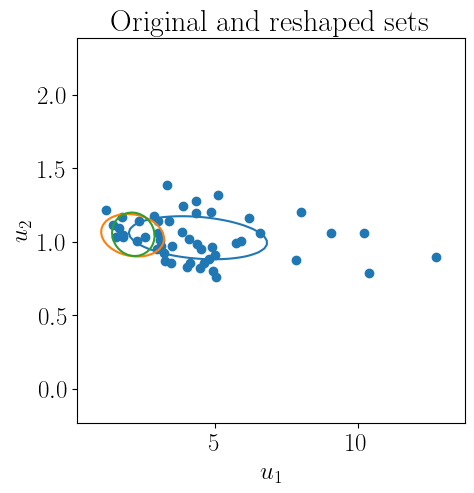

In [10]:
import os
import imageio

filenames = []
for i in range(len(A1_iters)):
    unc_level, g_level = level_set(A1_iters[i], b1_iters[i])
    plt.figure(figsize=(5, 5))
    plt.title("Original and reshaped sets")
    # Set axis label for the contour plot
    plt.xlabel(r"$u_1$")
    plt.ylabel(r"$u_2$")

    plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"], label = "initial sets")
    plt.contour(x_mesh,y_mesh,unc_level, [1], colors = ["tab:orange"], label = "final train")
    plt.contour(x_mesh,y_mesh,unc_level_learned, [1], colors = ["tab:green"], label = "initial train A,b")

    filename = f'gif_images/{i}.png'
    filenames.append(filename)

    plt.scatter(data[:,0],data[:,1])
    plt.savefig(filename)
    plt.close()

with imageio.get_writer('mygif4.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


    

## MRO set

In [17]:
n = 2
N = 50
# k = npr.uniform(1,4,n)
# p = k + npr.uniform(2,5,n)
k = np.array([2.,3.])
p = np.array([3,4.5])
k_tch = torch.tensor(k, requires_grad = True)
p_tch = torch.tensor(p, requires_grad = True)

b = npr.uniform(1,3,2)

### Define Problem Structure

In [6]:
K = 3
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.MRO(K = K, p=2,
                                                    data=data, loss = loss, uniqueA = True))
Astart = u.uncertainty_set._initA

# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()

objective = cp.Minimize(t)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [x_r >= 0]

prob = lro.RobustProblem(objective, constraints)

### Solve Problem

In [18]:
s = 13

# init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
# init_b = -init@np.mean(data, axis=0)
init = np.eye(2)
b = -init@np.mean(data, axis=0)

# Train A and b
result1 = prob.train(lr = 0.001, step=100, momentum = 0.8, optimizer = "SGD", seed = s, initA = init, initb = None, fixb = False, save_iters = True)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b
A1_iters, b1_iters = result1.uncset_iters




In [19]:
def solve_mro(A_in, data_in = data):
    K_in = (int) (A_in.shape[0] / A_in.shape[1])
    n = 2
    u = lro.UncertainParameter(n,
                        uncertainty_set=lro.MRO(p=2,K = K_in,
                                                    A = A_in,data = data_in, train = False, uniqueA = True))
    # Formulate the Robust Problem
    x_r = cp.Variable(n)
    t = cp.Variable()

    objective = cp.Minimize(t)

    constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
    constraints += [x_r >= 0]

    prob = lro.RobustProblem(objective, constraints)
    prob.solve()
    # result3.reform_problem.solve()
    x_opt = x_r.value
    t_opt = t.value
    return x_opt, t_opt

In [11]:
x_opt_base, t_opt_base = solve_mro(Astart)
x_opt_learned, t_opt_learned = solve_mro(A_fin)


In [14]:
offset = 1
x_min, x_max = np.min(data[:,0]) - offset, np.max(data[:,0]) + offset
y_min, y_max = np.min(data[:,1]) - offset, np.max(data[:,1]) + offset
n_points = 100
X = np.linspace(x_min,x_max,n_points)
Y = np.linspace(y_min,y_max,n_points)
x_mesh,y_mesh = np.meshgrid(X,Y)
# Z values as a matrix

def mro_level_sets(A, offset = 2, num_p = n_points, x_mesh = x_mesh, y_mesh = y_mesh):

    x_opt, t_opt = solve_mro(A)
    unc_set = {}
    K = (int) (A.shape[0] / A.shape[1])

    for k_ind in range(K):
        unc_set[k_ind] = np.zeros((num_p,num_p))
        
    # init_set = np.zeros((num_p,num_p))
    g_level= np.zeros((num_p,num_p))
    # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
    for i in range(num_p):
        for j in range(num_p):
            u_vec = [x_mesh[i,j], y_mesh[i,j]]
            for k_ind in range(K):
                unc_set[k_ind][i,j] = np.linalg.norm(A[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  - A[k_ind*n:(k_ind+1)*n, 0:n]@u.uncertainty_set.Dbar[k_ind])

            g_level[i,j] = np.maximum(k @ x_opt - p @ x_opt_base, k @ x_opt - p @ u_vec)

    return unc_set, g_level

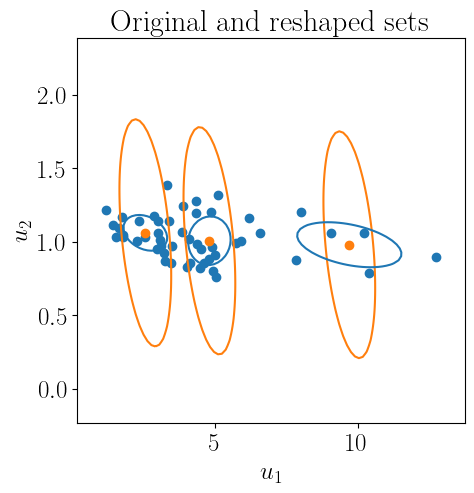

In [20]:
fin_set, g_level_learned = mro_level_sets(A_fin)
init_set, g_level_init = mro_level_sets(Astart)  

plt.figure(figsize=(5, 5))
plt.title("Original and reshaped sets")
# Set x axis label for the contour plot
plt.xlabel(r"$u_1$")
# Set y axis label for the contour plot

plt.ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
for k_ind in range(K):
    plt.contour(x_mesh,y_mesh,fin_set[k_ind], [1], colors = ["tab:orange"])
for k_ind in range(K):
    plt.contour(x_mesh,y_mesh,init_set[k_ind], [1], colors = ["tab:blue"])


# a = plt.contour(x_mesh,y_mesh,g_level_learned, np.arange(-10,12,5), colors = ["tab:orange"], alpha = 0.8)
# b = plt.contour(x_mesh,y_mesh,g_level_init, np.arange(-10,12,5), colors = ["tab:blue"],alpha = 0.8)

# plt.clabel(a, a.levels, inline=True, fmt=fmt, fontsize=18)
# plt.clabel(b, b.levels, inline=True, fmt=fmt, fontsize=18)
plt.scatter(data[:,0],data[:,1])
plt.scatter(u.uncertainty_set.Dbar[:,0], u.uncertainty_set.Dbar[:,1])
plt.savefig("Reshaped1.pdf", bbox_inches='tight')
plt.show()


In [16]:
import os
import imageio

filenames = []
for i in range(len(A1_iters)):
    unc_level, g_level = mro_level_sets(A1_iters[i])
    plt.figure(figsize=(5, 5))
    plt.title("Original and reshaped sets")
    # Set axis label for the contour plot
    plt.xlabel(r"$u_1$")
    plt.ylabel(r"$u_2$")

    for k_ind in range(K):
        plt.contour(x_mesh,y_mesh,fin_set[k_ind], [1], colors = ["tab:orange"])
        plt.contour(x_mesh,y_mesh,init_set[k_ind], [1], colors = ["tab:blue"])
        plt.contour(x_mesh,y_mesh,unc_level[k_ind], [1], colors = ["tab:green"])
    

    

    filename = f'gif_images/{i}.png'
    filenames.append(filename)

    plt.scatter(data[:,0],data[:,1])
    plt.scatter(u.uncertainty_set.Dbar[:,0], u.uncertainty_set.Dbar[:,1])
    plt.savefig(filename)
    plt.close()

with imageio.get_writer('mro.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [114]:
# Formulate constants
n = 2
N = 50
# k = npr.uniform(1,4,n)
# p = k + npr.uniform(2,5,n)
k = np.array([2.,3.])
p = np.array([3,4.5])
k_tch = torch.tensor(k, requires_grad = True)
p_tch = torch.tensor(p, requires_grad = True)

# Formulate loss function
def loss(t,x, data,l = 5): 
    return t + l*torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True))), t, torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True)))

def gen_demand(n, N):
    np.random.seed(2)
    F = np.random.normal(size = (n,2))
    sig = 0.1*F@(F.T)
    mu = np.random.uniform(-0.2,3,n)
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train

# Generate data
data = gen_demand(n,N)